In [1]:
import sys
import calendar
import glob
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import xesmf as xe

sys.path.append('/g/data/xv83/quantile-mapping/qqscale')
import utils

In [2]:
model = 'MPI-ESM1-2-HR'
obs = 'AGCD'

In [3]:
hist_dict = {
    'ACCESS-CM2': sorted(glob.glob('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/pr/gn/v20210607/pr_day_ACCESS-CM2_historical_r4i1p1f1_gn_*.nc')),
    'ACCESS-ESM1-5': sorted(glob.glob('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/day/pr/gn/v20200529/pr_day_ACCESS-ESM1-5_historical_r6i1p1f1_gn_*.nc')),
    'CESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/day/pr/gn/v20190514/*.nc')),
    'CMCC-ESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/CMCC/CMCC-ESM2/historical/r1i1p1f1/day/pr/gn/v20210114/pr_day_CMCC-ESM2_historical_r1i1p1f1_gn_*.nc')),
    'CNRM-ESM2-1': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/day/pr/gr/v20181206/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_*.nc')),
    'EC-Earth3': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/day/pr/gr/v20200310/pr_day_EC-Earth3_historical_r1i1p1f1_gr_*.nc')),
    'MPI-ESM1-2-HR': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/day/pr/gn/v20190710/pr_day_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_*.nc')),
    'NorESM2-MM': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_*.nc')),
    'UKESM1-0-LL': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/pr/gn/v20190627/pr_day_UKESM1-0-LL_historical_r1i1p1f2_gn_*.nc')),
}

ssp_dict = {
    'ACCESS-CM2': sorted(glob.glob('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp370/r4i1p1f1/day/pr/gn/v20210712/*.nc')),
    'ACCESS-ESM1-5': sorted(glob.glob('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r6i1p1f1/day/pr/gn/v20200908/*.nc')),
    'CESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/NCAR/CESM2/ssp370/r11i1p1f1/day/pr/gn/v20200528/*.nc')),
    'CMCC-ESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp370/r1i1p1f1/day/pr/gn/v20210202/*.nc')),
    'CNRM-ESM2-1': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp370/r1i1p1f2/day/pr/gr/v20191021/*.nc')),
    'EC-Earth3': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp370/r1i1p1f1/day/pr/gr/v20200310/*.nc')),
    'MPI-ESM1-2-HR': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1-2-HR/ssp370/r1i1p1f1/day/pr/gn/v20190710/*.nc')),
    'NorESM2-MM': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ssp370/r1i1p1f1/day/pr/gn/v20191108/*.nc')),
    'UKESM1-0-LL': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r1i1p1f2/day/pr/gn/v20190726/*.nc')),
}

In [4]:
hist_files = hist_dict[model]
ref_files = ssp_dict[model]
qq_cmatch_files = sorted(glob.glob(f"/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/{obs}/{model}/ssp370/r*/day/pr/2070-2099/pr_day_{model}_ssp370_r*_*_*_qdc-multiplicative-monthly-q100-linear-maxaf5-annual-change-matched_{obs}-baseline-1985-2014_model-baseline-1985-2014.nc"))

In [5]:
ds_qq = utils.read_data(
    qq_cmatch_files,
    'pr',
    time_bounds=['2070', '2099'],
)
try:
    ds_qq = ds_qq.drop_vars('crs')
except ValueError:
    pass
da_qq_monthly = ds_qq['pr'].resample(time='M').sum(dim='time', keep_attrs=True)
da_qq_clim = da_qq_monthly.groupby('time.month').mean('time').compute()

In [6]:
if obs == 'BARRA-R2':
    var = 'pr'
    target_files = sorted(glob.glob("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/v20240809/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc"))
    ds_target = utils.read_data(
        target_files,
        var,
        time_bounds=['1985', '2014'],
        input_units="kg m-2 s-1",
        output_units="mm day-1",
    )
elif obs == 'AGCD':
    var = 'precip'
    target_files = sorted(glob.glob("/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_*_daily.nc"))
    ds_target = utils.read_data(
        target_files,
        var,
        time_bounds=['1985', '2014'],
        input_units="mm day-1",
        output_units="mm day-1",
    )

try:
    ds_target = ds_target.drop_vars('crs')
except ValueError:
    pass
da_target_monthly = ds_target[var].resample(time='M').sum(dim='time', keep_attrs=True)
da_target_clim = da_target_monthly.groupby('time.month').mean('time').compute()

In [7]:
ds_hist = utils.read_data(
    hist_files,
    'pr',
    time_bounds=['1985', '2014'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
)
try:
    ds_hist = ds_hist.drop_vars('crs')
except ValueError:
    pass
da_hist_monthly = ds_hist['pr'].resample(time='M').sum(dim='time', keep_attrs=True)
da_hist_clim = da_hist_monthly.groupby('time.month').mean('time').compute()

In [8]:
regridder = xe.Regridder(da_hist_clim, da_qq_clim, 'bilinear')
da_hist_clim_regridded = regridder(da_hist_clim)
da_hist_clim_regridded = da_hist_clim_regridded.compute()

In [9]:
ds_ref = utils.read_data(
    ref_files,
    'pr',
    time_bounds=['2070', '2099'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
)
try:
    ds_ref = ds_ref.drop_vars('crs')
except ValueError:
    pass
da_ref_monthly = ds_ref['pr'].resample(time='M').sum(dim='time', keep_attrs=True)
da_ref_clim = da_ref_monthly.groupby('time.month').mean('time').compute()

In [10]:
regridder = xe.Regridder(da_ref_clim, da_qq_clim, 'bilinear')
da_ref_clim_regridded = regridder(da_ref_clim)
da_ref_clim_regridded = da_ref_clim_regridded.compute()

In [11]:
city_lat_lon = {
    'Port Hedland': (-20.3, 118.6), 
    'Darwin': (-12.5, 130.8),
    'Mount Isa': (-20.8, 139.5),
    'Cairns': (-16.9, 145.8),
    'Brisbane': (-27.5, 153.0),
    'Sydney': (-33.9, 151.2),
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Mildura': (-34.2, 142.1),
    'Adelaide': (-34.9, 138.6),
    'Alice Springs': (-23.7, 133.9),
    'Perth': (-32.0, 115.9),
}

##    'Thredbo': (-36.5, 148.3),
##    'Karlamilyi_National_Park': (-22.7, 122.2),

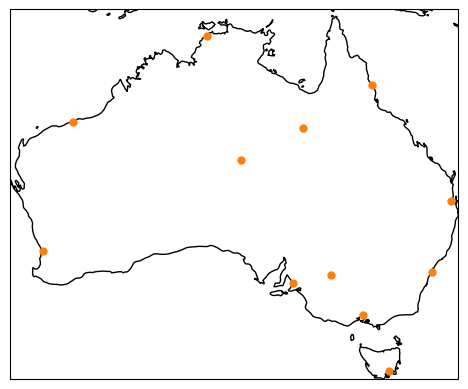

In [12]:
fig = plt.figure()#figsize=[24, 6])

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()

for city in city_lat_lon:
    lat, lon = city_lat_lon[city]
    ax.plot(
        lon,
        lat,
        marker='o',
        markerfacecolor='tab:orange',
        markeredgecolor='none',
#        zorder=5,
#        label=city,
        transform=ccrs.PlateCarree()
    )
#ax.legend()
xmin = 112.92
xmax = 153.63
ymin = -43.625
ymax = -10.07
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
plt.show()

In [13]:
def plot_city(ax, city, plotnum):
    """Plot a location"""
    
    lat, lon = city_lat_lon[city]
    point_selection = {'lat': lat, 'lon': lon}
    
    da_hist_point_clim = da_hist_clim_regridded.sel(point_selection, method='nearest')
    da_ref_point_clim = da_ref_clim_regridded.sel(point_selection, method='nearest')
    da_target_point_clim = da_target_clim.sel(point_selection, method='nearest')
    da_qq_point_clim = da_qq_clim.sel(point_selection, method='nearest')
    
    xticks = np.arange(1, 13)
    xtick_labels = [calendar.month_abbr[i][0] for i in xticks]

    ax.plot(xticks, da_hist_point_clim, label='historical (1985-2014)', linestyle=':', color='tab:orange', marker='o')
    ax.plot(xticks, da_ref_point_clim, label='SSP3-7.0 (2070-2099)', linestyle='-', color='tab:orange', marker='o')
    ax.plot(xticks, da_target_point_clim, label=f'{obs} (1985-2014)', linestyle=':', color='tab:blue', marker='o')
    ax.plot(xticks, da_qq_point_clim, label='QDC (2070-2099)', linestyle='-', color='tab:blue', marker='o')

    ax.set_title(city)
    if plotnum == 0:
        ax.legend(fontsize='small')
    if plotnum in [0, 3, 6, 9]:
        ax.set_ylabel('monthly mean precipitation (mm)')
    ax.set_xticks(xticks, xtick_labels)
    ax.grid()

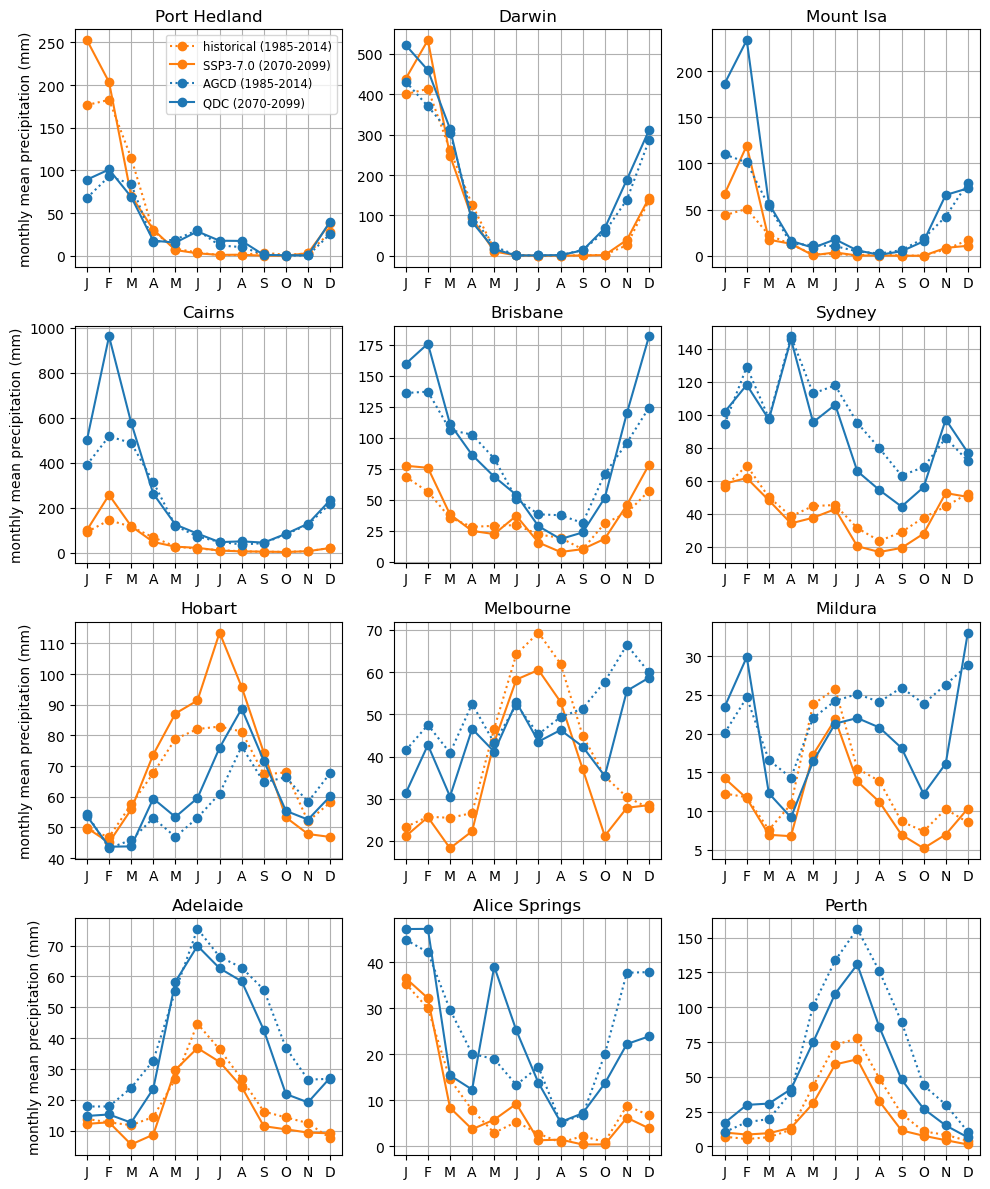

In [14]:
fig, axes = plt.subplots(4, 3, figsize=[10, 12])
axes = axes.flatten()
for plotnum, city in enumerate(city_lat_lon):
    plot_city(axes[plotnum], city, plotnum) 
fig.tight_layout()
plt.savefig(
    f'pr_monthly-clim_{model}_ssp370_r1i1p1f1_AUS_2070-2099_qdc-multiplicative-monthly-q100-linear-maxaf5-annual-change-matched_{obs}-baseline-1985-2014_model-baseline-1985-2014.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()

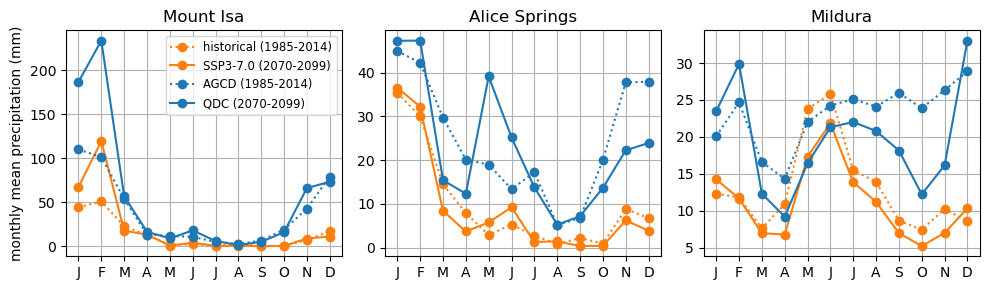

In [17]:
fig, axes = plt.subplots(1, 3, figsize=[10, 3])
axes = axes.flatten()
for plotnum, city in enumerate(['Mount Isa', 'Alice Springs', 'Mildura']):
    plot_city(axes[plotnum], city, plotnum) 
fig.tight_layout()
plt.savefig(
    f'pr_monthly-clim_{model}_ssp370_r1i1p1f1_feature-cities_2070-2099_qdc-multiplicative-monthly-q100-linear-maxaf5-annual-change-matched_{obs}-baseline-1985-2014_model-baseline-1985-2014.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()